In [348]:
using Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `~/Desktop/Work/Research/LEGO-project/LEGO-3D_Dyn`


In [349]:
import ForwardDiff as FD
using LinearAlgebra
using Plots

### Quaternions

In [350]:
function hat(v::Vector)::Matrix
  # generate skew symmetric matrix from vector
  return [0 -v[3] v[2];
    v[3] 0 -v[1];
    -v[2] v[1] 0]
end

function L(Q::Vector)::Matrix
  # left multiply matrix of quaternion Q
  s = Q[1] # scalar part
  v = Q[2:end] # vector part
  return [s -v'; v hat(v)+s*I]
end

function R(Q::Vector)::Matrix
  # right multiply matrix of quaternion Q
  s = Q[1] # scalar part
  v = Q[2:end] # vector part
  return [s -v'; v hat(v)-s*I]
end

H = [zeros(1, 3); I]; # hat map for vectors

T = Diagonal([1; -ones(3)]); # quaternion conjugation matrix

function G(Q::Vector)::Matrix
  # generate attitude jacobian from quaternion Q
  return L(Q) * H
end

function quat2rot(Q::Vector)::Matrix
  # convert quaternion to rotation matrix
  return H' * L(Q) * R(Q) * H
end

quat2rot (generic function with 1 method)

### Dynamics

In [351]:
function states2tuple(states::Vector)
  """
  # Separate state vectors into position, and attitude

  # Arguments
  - `states`: Vector containing states of the body

  # Returns
  - `states_tuple`: NamedTuple containing separated states
  """
  qᴺ = states[1:3] # position of the rigidbody in world frame
  @show states[1]

  if length(states) == 3
    states_tuple = (qᴺ = qᴺ)
  elseif length(states) == 7
    ᴺQᴮ = states[4:7] # orientation of the rigidbody in inertial frame
    states_tuple = (qᴺ=qᴺ, ᴺQᴮ=ᴺQᴮ) # separated states
  else
    throw("Invalid state vector")
  end
  return states_tuple
end

function potential_energy(state::Vector, params_rb::NamedTuple)
  """
  # Calculate potential energy of the body

  # Arguments
  - `state`: Vector containing states of the body
  - `params_rb`: NamedTuple containing rigidbody parameters

  # Returns
  - `U`: potential energy of the system
  """
  # q = states2tuple(state).qᴺ
  q = state[1:3]
  z = q[3]
  m, g = params_rb.m, params_rb.g
  U = m * g * z
  return U
end

# left momentum term of the linear discrete euler lagrange equation
function D2Ll(state1::Vector, state2::Vector, h::Float64, params_rb::NamedTuple)
  """
  # Calculate left momentum term of the discrete euler lagrange equation

  # Arguments
  - `state1`: Vector containing states of the body at time t
  - `state2`: Vector containing states of the body at time t + h
  - `h`: time step
  - `params_rb`: NamedTuple containing rigidbody parameters

  # Returns
  - `p⁺`: left momentum term
  """
  # q1, q2 = states2tuple(state1).qᴺ, states2tuple(state2).qᴺ
  q1, q2 = state1[1:3], state2[1:3]
  m = params_rb.m
  q̄ = (q1 + q2) / 2 # midpoint position
  v̄ = (q2 - q1) / h # average velocity
  ∇U = FD.gradient(state -> potential_energy(state, params_rb), q̄)
  p⁺ = m * v̄ - h / 2 * ∇U # left momentum term
  return p⁺
end

# right momentum term of the linear discrete euler lagrange equation
function D1Ll(state1::Vector, state2::Vector, h::Float64, params_rb::NamedTuple)
  """
  # Calculate right momentum term of the discrete euler lagrange equation

  # Arguments
  - `state1`: Vector containing states of the body at time t
  - `state2`: Vector containing states of the body at time t + h
  - `h`: time step
  - `params_rb`: NamedTuple containing rigidbody parameters

  # Returns
  - `_p⁻`: right momentum term
  """
  # q1, q2 = states2tuple(state1).qᴺ, states2tuple(state2).qᴺ
  q1, q2 = state1[1:3], state2[1:3]
  m = params_rb.m
  q̄ = (q1 + q2) / 2 # midpoint position
  v̄ = (q2 - q1) / h # average velocity
  ∇U = FD.gradient(state -> potential_energy(state, params_rb), q̄)
  _p⁻ = -m * v̄ - h / 2 * ∇U # negative of right momentum term
  return _p⁻
end

function linear_momentum_DEL(
  momentum1::Vector,
  state1::Vector,
  state2::Vector,
  cg_force1::Vector,
  cg_force2::Vector,
  params_rb::NamedTuple,
  h::Float64)
  """
  # Calculate discrete Lagrangian of the body

  # Arguments
  - `momentum1`: Vector containing momentum of the body at time t
  - `state1`: Vector containing states of the body at time t
  - `state2`: Vector containing states of the body at time t + h
  - `cg_force1`: Vector containing forcing terms at time t - h/2
  - `cg_force2`: Vector containing forcing terms at time t + h/2
  - `params_rb`: NamedTuple containing rigidbody parameters
  - `h`: time step

  # Returns
  - `lm_DEL`: residual of the discrete linear momentum Lagrangian of the body using midpoint integration
  """
  linear_momentum = momentum1[1:3]
  lm_DEL = linear_momentum + D1Ll(state1, state2, h, params_rb) + h / 2 * (cg_force1 + cg_force2)
  return lm_DEL
end

linear_momentum_DEL (generic function with 1 method)

In [352]:
function D2Lr(state1::Vector, state2::Vector, h::Float64, params_rb::NamedTuple)
  """
  # Calculate left momentum term of the discrete euler lagrange equation

  # Arguments
  - `state1`: Vector containing states of the body at time tₖ
  - `state2`: Vector containing states of the body at time tₖ + h
  - `h`: time step
  - `params_rb`: NamedTuple containing rigidbody parameters

  # Returns
  - `l⁺`: left momentum term
  """
  # Q1, Q2 = states2tuple(state1).ᴺQᴮ, states2tuple(state2).ᴺQᴮ
  Q1, Q2 = state1[4:7], state2[4:7]
  J = params_rb.J
  # calculate the right momentum term
  l⁺ = 2 / h * G(Q2)' * L(Q1) * H * J * H' * L(Q1)' * Q2
  return l⁺
end

function D1Lr(state1::Vector, state2::Vector, h::Float64, params_rb::NamedTuple)
  """
  # Calculate right momentum term of the discrete euler lagrange equation

  # Arguments
  - `state1`: Vector containing states of the body at time t
  - `state2`: Vector containing states of the body at time t + h
  - `h`: time step
  - `params_rb`: NamedTuple containing rigidbody parameters

  # Returns
  - `_l⁻`: negative of the right momentum term
  """
  # Q1, Q2 = states2tuple(state1).ᴺQᴮ, states2tuple(state2).ᴺQᴮ
  Q1, Q2 = state1[4:7], state2[4:7]
  J = params_rb.J
  # calculate the right momentum term
  _l⁻ = 2 / h * (G(Q1)' * T * R(Q2)' * H * J * H' * L(Q1)' * Q2) # negative of right momentum term
  return _l⁻
end

function rotational_momentum_DEL(
  momentum1::Vector,
  state1::Vector,
  state2::Vector,
  torque1::Vector,
  torque2::Vector,
  params_rb::NamedTuple,
  h::Float64)
  """
  # Calculate discrete Lagrangian of the body

  # Arguments
  - `momentum1`: Vector containing momentum of the body at time t
  - `state1`: Vector containing states of the body at time t
  - `state2`: Vector containing states of the body at time t + h
  - `torque1`: Vector containing torques at time t - h/2
  - `torque2`: Vector containing torques at time t + h/2
  - `params_rb`: NamedTuple containing rigidbody parameters
  - `h`: time step

  # Returns
  - `rm_DEL`: residual of the discrete Lagrangian of the body using midpoint integration
  """
  # calculate the discrete lagrangian
  angular_momentum = momentum1[4:6]
  rm_DEL = angular_momentum + D1Lr(state1, state2, h, params_rb) + (h / 2) * (torque1 + torque2)
  return rm_DEL
end

rotational_momentum_DEL (generic function with 1 method)

In [353]:
function complete_DEL(
  momenta1::Matrix,
  states1::Matrix,
  states2::Matrix,
  forcing1::Matrix,
  forcing2::Matrix,
  params_rbs::Vector{<:NamedTuple},
  h::Float64)
  """
  # Calculate discrete Lagrangian of the system

  # Arguments
  - `momenta1`: Matrix containing momenta of the system at time t (each column is a rigidbody)
  - `state1`: Matrix containing states of the system at time t
  - `state2`: Matrix containing states of the system at time t + h
  - `forcing1`: Matrix containing forcing (Fx,Fy,Fz,τx,τy,τz) terms at time t - h/2 
  - `forcing2`: Matrix containing forcing terms at time t + h/2
  - `params_rb`: NamedTuple containing rigidbody parameters
  - `h`: time step

  # Returns
  - `DEL`: residual of the discrete Lagrangian of the system using midpoint integration
  """
  DEL = []
  for i in 1:size(momenta1, 2)
    append!(DEL, linear_momentum_DEL(
      momenta1[:, i],
      states1[:, i],
      states2[:, i],
      forcing1[1:3, i],
      forcing2[1:3, i],
      params_rbs[i],
      h))
    append!(DEL, rotational_momentum_DEL(
      momenta1[:, i],
      states1[:, i],
      states2[:, i],
      forcing1[4:6, i],
      forcing2[4:6, i],
      params_rbs[i],
      h))
  end
  return DEL
end

function complete_DEL_jacobian(
  momenta1::Matrix,
  states1::Matrix,
  states2::Matrix,
  forcing1::Matrix,
  forcing2::Matrix,
  params_rbs::Vector{<:NamedTuple},
  h::Float64)
  """
  # Calculate jacobian of the discrete Lagrangian of the system

  # Arguments
  - `momenta1`: Matrix containing momenta of the system at time t (each column is a rigidbody)
  - `state1`: Matrix containing states of the system at time t
  - `state2`: Matrix containing states of the system at time t + h
  - `forcing1`: Matrix containing forcing (Fx,Fy,Fz,τx,τy,τz) terms at time t - h/2
  - `forcing2`: Matrix containing forcing terms at time t + h/2
  - `params_rb`: NamedTuple containing rigidbody parameters
  - `h`: time step

  # Returns
  - `complete_jacobian`: residual of the discrete Lagrangian of the system using midpoint integration
  """
  vanilla_jacobian = FD.jacobian(s2 -> complete_DEL(momenta1, states1, s2, forcing1, forcing2, params_rbs, h), states2)
  Ḡ = attitude_jacobian_block_matrix(states2, params_rbs)
  complete_jacobian = vanilla_jacobian * Ḡ
  return complete_jacobian
end

function attitude_jacobian_block_matrix(states::Matrix, params_rbs::Vector{<:NamedTuple})
  bodies = length(params_rbs)
  attitude_jacobian_matrix = zeros(7 * bodies, 6 * bodies)
  for i in 1:bodies
    # multiply rows of rotational DEL with attitude jacobian, the rest with identity
    attitude = states[4:7, i]
    attitude_jacobian_matrix[7*i-6:7*i-4, 6*i-5:6*i-3] = I(3)
    attitude_jacobian_matrix[7*i-3:7*i, 6*i-2:6*i] = G(attitude)
  end
  return attitude_jacobian_matrix
end

# TODO: add constraint terms

function integrator_step(momenta1, states1, forcing1, forcing2, params_rbs, h; tol=1e-6, max_iters=100)

  states2 = states1 # initial guess
  residual = complete_DEL(momenta1, states1, states2, forcing1, forcing2, params_rbs, h)
  bodies = length(params_rbs)

  for i in 1:max_iters
    if norm(residual) < tol
      momenta2 = 0 * momenta1
      for i in 1:bodies
        momenta2[:, i] = [
          D2Ll(states1[:, i], states2[:, i], h, params_rbs[i]);
          D2Lr(states1[:, i], states2[:, i], h, params_rbs[i])]
      end
      # momenta2 = [D2Ll(momenta1, states1, states2, h, params_rbs); D2Lr(momenta1, states1, states2, h, params_rbs)]
      return states2, momenta2
    end
    DEL_jacobian = complete_DEL_jacobian(momenta1, states1, states2, forcing1, forcing2, params_rbs, h)
    # wrapping in real helped fixed some random matrix solve error
    Δstates = -real(DEL_jacobian) \ real(residual)
    # TODO: fix so generalizable to multiple bodies
    states2[1:3] += Δstates[1:3]
    states2[4:7] .= L(states2[4:7]) * [sqrt(1 - Δstates[4:6]' * Δstates[4:6]); Δstates[4:6]]
    # states2_splatted = attitude_jacobian_block_matrix(states2, params_rbs) * Δstates
    # states2 += reshape(states2_splatted, 7, bodies)
    residual = complete_DEL(momenta1, states1, states2, forcing1, forcing2, params_rbs, h)
    @show real(residual)
  end

  throw("Integration did not converge")
end

function mom2vel(mom::Vector, params_rb::NamedTuple)
  """
  # Calculate velocity from momentum

  # Arguments
  - `mom`: Vector containing momentum of the body
  - `params_rb`: NamedTuple containing rigidbody parameters

  # Returns
  - `vel`: velocity of the body
  """
  m = params_rb.m
  J = params_rb.J
  vel = [mom[1:3] / m; J \ mom[4:end]]
  return vel
end

function vel2mom(vel::Vector, params_rb::NamedTuple)
  """
  # Calculate momentum from velocity

  # Arguments
  - `vel`: Vector containing velocity of the body
  - `params_rb`: NamedTuple containing rigidbody parameters

  # Returns
  - `mom`: momentum of the body
  """
  m = params_rb.m
  J = params_rb.J
  mom = [m * vel[1:3]; J * vel[4:end]]
  return mom
end

vel2mom (generic function with 1 method)

### Simulation paramters

In [354]:
h = 0.01 # 20 Hz
T_final = 5 # final time
T_hist = Array(0:h:T_final)
N = length(T_hist)

# model parameters
params_link1 = (m=1.0, J=Diagonal([0.1, 1.0, 1.0]), g=0) # rigidbody parameters

m1 = params_link1.m
J1 = params_link1.J

# initial conditions
link1_state0 = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] # initial state of the rigidbody
link1_vel0 = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0] # initial velocity of the rigidbody
link1_momentum0 = vel2mom(link1_vel0, params_link1) # initial momentum of the rigidbody

# forcing terms
no_forcing = zeros(6) # no external forces

# integrate
state_hist = zeros(7, N)
momentum_hist = zeros(6, N)

state_hist[:, 1] = link1_state0
momentum_hist[:, 1] = link1_momentum0

for i in 2:N
  state_hist[:, i], momentum_hist[:, i] = integrator_step(
    hcat(momentum_hist[:, i-1]),
    hcat(state_hist[:, i-1]),
    hcat(no_forcing),
    hcat(no_forcing),
    [params_link1],
    h)
end

real(residual) = [0.0, 0.0, 0.0, 0.0, 0.9999999999999998, 0.0]


MethodError: MethodError: no method matching zero(::Type{Any})
Closest candidates are:
  zero(::Type{Union{Missing, T}}) where T at missing.jl:105
  zero(!Matched::Union{Type{P}, P}) where P<:Dates.Period at ~/julia-1.8.3/share/julia/stdlib/v1.8/Dates/src/periods.jl:53
  zero(!Matched::ForwardDiff.Partials) at ~/.julia/packages/ForwardDiff/PcZ48/src/partials.jl:39
  ...

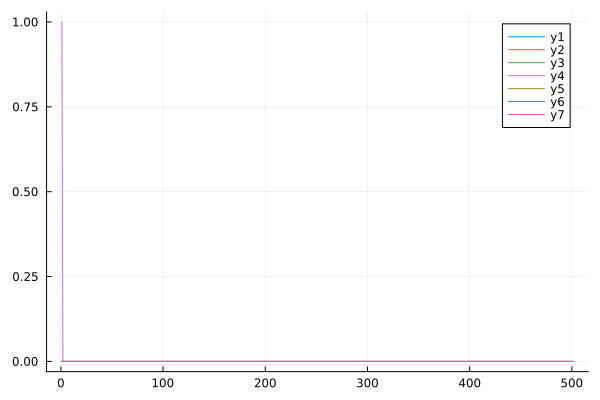

In [347]:
plot(state_hist')

### Visualization

In [289]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations

In [290]:
vis = Visualizer()
render(vis)

┌ Info: Listening on: 127.0.0.1:8701, thread id: 1
└ @ HTTP.Servers /home/sman/.julia/packages/HTTP/sJD5V/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/sman/.julia/packages/MeshCat/0RCA3/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8701, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8701), "127.0.0.1", "8701", nothing, Sockets.TCPServer(RawFD(30) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007f254515e570, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 139802181604096, 139798078294528)))))

In [291]:
delete!(vis)

green_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.8))
cylinder1 = Cylinder(Point(-.5, 0, 0), Point(0.5, 0, 0), 0.1)
setobject!(vis["cylinder1"],cylinder1,green_material)

for k = 1:N
    
    # set position and attitude
    position1 = Translation(state_hist[1:3,k]...)
    attitude1 = LinearMap(UnitQuaternion(state_hist[4:7,k]))
    
    settransform!(vis["cylinder1"], compose(position1,attitude1))
    sleep(0.05)
end